# Eligibility Traces

### Train

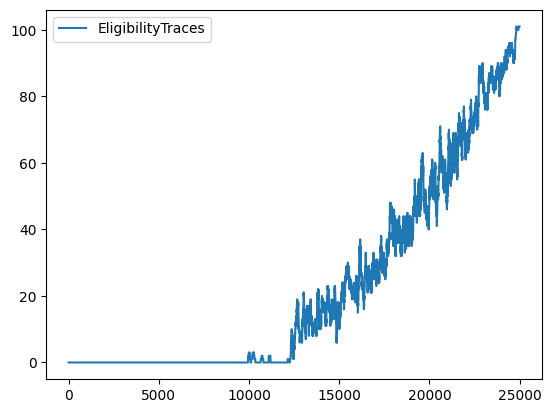

In [8]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from gym.envs.toy_text.frozen_lake import generate_random_map

def EligibilityTraces(episodes, env_seed):

    env = gym.make("FrozenLake-v1", desc=env_seed, map_name="12x12", is_slippery=False, render_mode=None)

    q = np.zeros((env.observation_space.n, env.action_space.n)) # init a 64 x 4 array
    eligibility_traces = np.zeros((env.observation_space.n, env.action_space.n))  # Initialize eligibility traces

    alpha = 0.9 # alpha or learning rate
    gamma = 0.25 # gamma or discount rate. Near 0: more weight/reward placed on immediate state. Near 1: more on future state.
    epsilon = 1         # 1 = 100% random actions
    epsilon_decay_rate = 1/episodes   # epsilon decay rate. 1/0.0001 = 10,000
    rng = np.random.default_rng()   # random number generator

    rewards_per_episode = np.zeros(episodes)

    for i in range(episodes):
        state = env.reset()[0]  # states: 0 to 63, 0=top left corner,63=bottom right corner
        terminated = False      # True when fall in hole or reached goal
        truncated = False       # True when actions > 200

        while(not terminated and not truncated):
            if rng.random() < epsilon:
                action = env.action_space.sample() # actions: 0=left,1=down,2=right,3=up
            else:
                action = np.argmax(q[state,:])

            new_state,reward,terminated,truncated,_ = env.step(action)
            if reward == 1:
                reward = 0
            elif terminated:
                reward = -99
            else:
                reward = -1

            # Update eligibility traces
            eligibility_traces *= gamma # Decay traces
            eligibility_traces[state, action] += 1  # Increment trace for visited state-action pair

            # Q-learning update with eligibility traces
            delta = reward + gamma * np.max(q[new_state, :]) - q[state, action]
            q += alpha * delta * eligibility_traces

            state = new_state

        epsilon = max(epsilon - epsilon_decay_rate, 0)

        if(epsilon==0):
            alpha = 1/episodes

        if reward == 0:
            rewards_per_episode[i] = 1
    env.close()

    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])

    plt.plot(sum_rewards, label="EligibilityTraces")
    plt.legend()

    plt.savefig('images/frozen_lake_EligibilityTraces.png')
    return q


size = 12
env_seed = generate_random_map(size=size)
EligibilityTraces_model = EligibilityTraces(25000, env_seed)


### Test

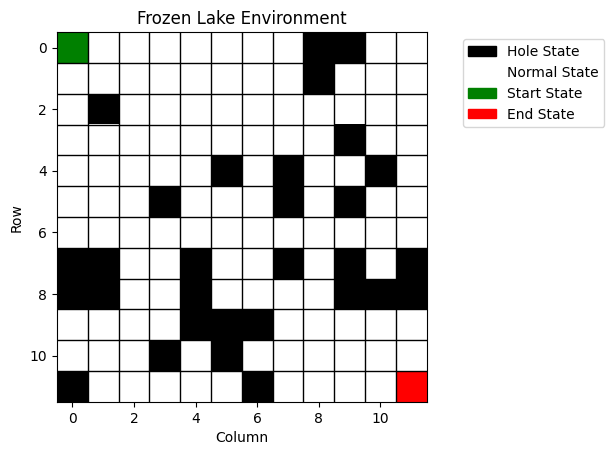

In [9]:
import FrozenLakeFunctions as flf
import imp
imp.reload(flf)

env_array = flf.seeEnv(env_seed, size)

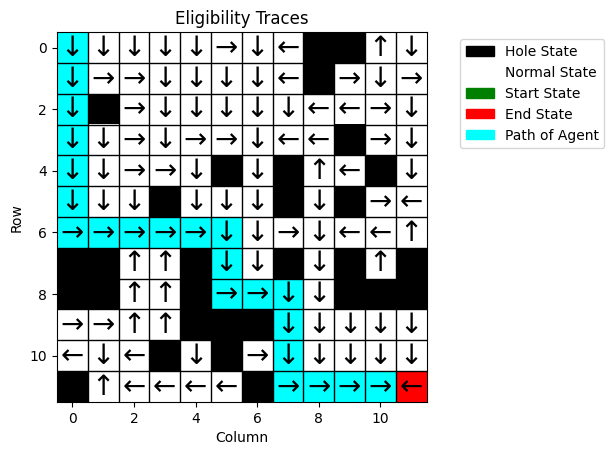

In [14]:
import FrozenLakeFunctions as flf
import imp
imp.reload(flf)

flf.visualize_QTable(EligibilityTraces_model, "Eligibility Traces", size, env_array, env_seed)
flf.seeModel(EligibilityTraces_model, env_seed)

### A Low Episode Count of Eligibility Traces Won't Work

/home/joshua/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.desc to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.desc` for environment variables or `env.get_wrapper_attr('desc')` that will search the reminding wrappers.
  logger.warn(


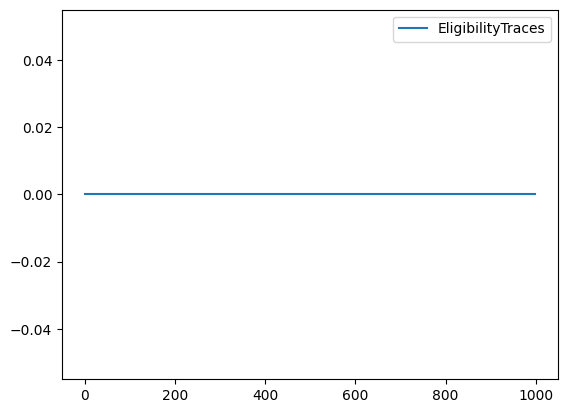

In [15]:
EligibilityTraces_model1 = EligibilityTraces(1000, env_seed)
env_array = flf.getBoard(env_seed, size)

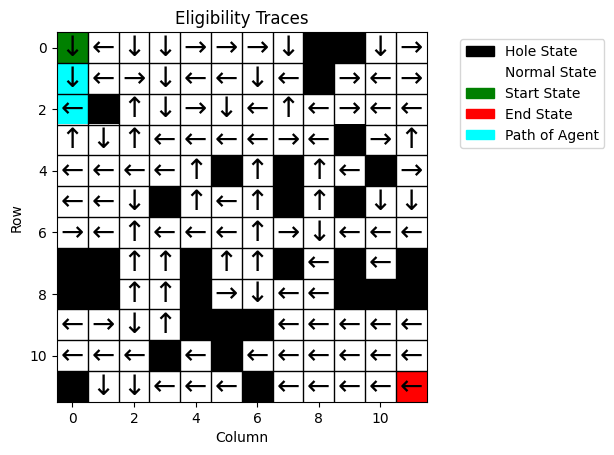

KeyboardInterrupt: 

: 

In [16]:
import FrozenLakeFunctions as flf
import imp
imp.reload(flf)

flf.visualize_QTable(EligibilityTraces_model1, "Eligibility Traces", size, env_array, env_seed)
flf.seeModel(EligibilityTraces_model1, env_seed)